In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import random
import json
from functools import reduce
from itertools import product
from operator import mul

In [3]:
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import time

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold

In [4]:
import os
def beep(duration=2, freq=440):
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))

In [5]:
# run PCA and check eigen values to find number of latent features
# use PCA output as features
# use LDA output as features
# use Matrix Factorization as features
# NMF factorization (>=0) NMF(log(X + 1))
# use AE bottleneck as features
# add submotivo as features
# find 20 clusters and make features as the L2-distance to each cluster
# use SVM output as features
# use stats features

# vowpal-wabbit linear models
# keras NN with dropout & batch norm

In [6]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [7]:
train = pd.read_csv('_data/train_independent.csv')
test = pd.read_csv('_data/test_independent.csv')

In [10]:
def run_model(model, X, y, dataset_desc='', params_desc=''):
    model_name = str(model.__class__).split('.')[-1].replace('>','').replace("'",'')
    print(model_name)
    auc = []
    logloss = []
    train_auc = []
    train_logloss = []
    start = int(time.time() * 1000)
    for train_idx, test_idx in kfolds.split(X, y):
        model.fit(X.iloc[train_idx,:], y[train_idx])
        
        y_ = model.predict_proba(X.iloc[test_idx,:])[:,1]
        auc += [roc_auc_score(y.iloc[test_idx], y_)]
        logloss += [log_loss(y.iloc[test_idx], y_)]
        
        y_ = model.predict_proba(X.iloc[train_idx,:])[:,1]
        train_auc += [roc_auc_score(y.iloc[train_idx], y_)]
        train_logloss += [log_loss(y.iloc[train_idx], y_)]
        
        print(logloss[-1], train_logloss[-1])
        
    end = int(time.time() * 1000)
    results.loc[len(results)] = [dataset_desc, model_name, params_desc,
                                 np.mean(auc), np.std(auc), 
                                 np.mean(logloss), np.std(logloss), str(end - start),
                                 np.mean(train_logloss), np.std(train_logloss),
                                 np.mean(train_auc), np.std(train_auc), 
                                 np.mean(logloss) - np.mean(train_logloss)]
    print(f'logloss: {np.mean(logloss)}, train_logloss: {np.mean(train_logloss)}')
#     winsound.Beep(2500, 1000)

In [8]:
model = SVC(kernel='linear', verbose=True)

In [9]:
model.fit(train.drop(['ID_CORRELATIVO', 'ATTRITION'], axis=1), 
          train['ATTRITION'])

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [13]:
params = {
    'C': 1,
    'kernel': 'linear',
    'verbose': True,
    'probability': True
}

In [ ]:
run_model(SVC(**params), 
          train.drop(['ID_CORRELATIVO', 'ATTRITION'], axis=1), 
          train['ATTRITION'], 
          'independent', str(params))

## PCA

In [15]:
from sklearn.decomposition import PCA

In [11]:
train.shape

(70000, 73)

In [22]:
pca = PCA(n_components=71)

In [23]:
pca.fit(
    pd.concat((train.drop(['ID_CORRELATIVO', 'ATTRITION'], axis=1),
              test.drop('ID_CORRELATIVO', axis=1))))

PCA(copy=True, iterated_power='auto', n_components=71, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0,0.5,'explained_variance_')

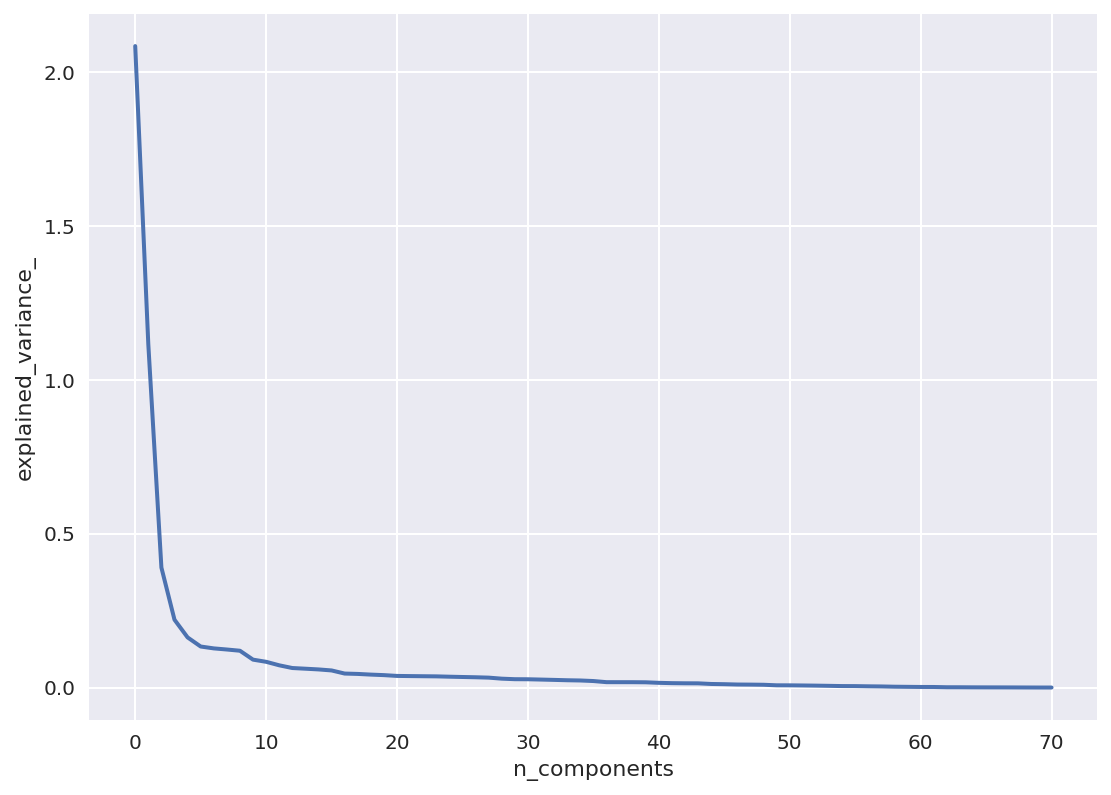

In [24]:
plt.figure(1, figsize=(10, 7))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [16]:
pca = PCA(n_components=30)

In [17]:
pca.fit(
    pd.concat((train.drop(['ID_CORRELATIVO', 'ATTRITION'], axis=1),
              test.drop('ID_CORRELATIVO', axis=1))))

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [18]:
train_pca = pca.transform(train.drop(['ID_CORRELATIVO', 'ATTRITION'], axis=1))

In [19]:
test_pca = pca.transform(test.drop('ID_CORRELATIVO', axis=1))

In [34]:
pd.DataFrame(train_pca).to_csv('train_pca.csv', index=False)

In [35]:
pd.DataFrame(test_pca).to_csv('test_pca.csv', index=False)

## t-SNE

In [11]:
from sklearn.manifold import TSNE

In [23]:
tsne = TSNE(n_components=3, verbose=3)

In [24]:
tsne.fit(np.concatenate((train_pca, test_pca)))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.354s...
[t-SNE] Computed neighbors for 100000 samples in 265.699s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional proba

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=3, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=None, verbose=3)

In [25]:
pd.DataFrame(tsne.embedding_).to_csv('train_test_tsne_3D.cvs', index=False)

In [ ]:
tsne.fit(
    pd.concat((train.drop(['ID_CORRELATIVO', 'ATTRITION'], axis=1),
              test.drop('ID_CORRELATIVO', axis=1))))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 13.626s...
[t-SNE] Computed neighbors for 100000 samples in 1955.626s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional pro

In [ ]:
train_tsne = tsne.transform(train.drop(['ID_CORRELATIVO', 'ATTRITION'], axis=1))

In [ ]:
test_tsne = tsne.transform(test.drop('ID_CORRELATIVO', axis=1))

In [ ]:
pd.DataFrame(train_tsne).to_csv('train_tsne.csv', index=False)

In [ ]:
pd.DataFrame(test_tsne).to_csv('test_tsne.csv', index=False)